# **COMPUTER VISION CAPSTONE PROJECT AIML OBJECT DETECTION - CAR**

**AWS Specific code**

**Installing libraries**

In [1]:
!pip install tensorflow opencv-python pillow scikit-learn

In [2]:
import os

In [3]:
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [4]:
!nvidia-smi

Sat Mar 29 10:40:41 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.144.03             Driver Version: 550.144.03     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A10G                    On  |   00000000:00:1E.0 Off |                    0 |
|  0%   33C    P8             16W /  300W |       1MiB /  23028MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
import boto3

In [6]:
def download_files_from_bucket(file,bucket):
     '''
     this function is for downloading the files from the bucket to the local instance
     '''    
     bucket_name = bucket
     file_key = file
     local_file_path = file
     s3 = boto3.client('s3')
     s3.download_file(bucket_name, file_key, local_file_path)    
     print(f"File downloaded to {local_file_path}")

In [7]:
download_files_from_bucket('stanford-car-dataset-by-classes-folder.zip','pgp-capstone-project')

File downloaded to stanford-car-dataset-by-classes-folder.zip


In [8]:
zip_file_path = 'stanford-car-dataset-by-classes-folder.zip'
!unzip -oq stanford-car-dataset-by-classes-folder.zip 

1. Problem Statement



Computer vision can be used to automate supervision and generate action appropriate action trigger if the event is
predicted from the image of interest. For example a car moving on the road can be easily identified by a camera as make of
the car, type, colour, number plates etc.

Design a DL based car identification model.

2. Introduction

The Cars dataset contains 16,185 images of 196 classes of cars. The data is split into 8,144 training images and 8,041 testing
images, where each class has been split roughly in a 50-50 split. Classes are typically at the level of Make, Model, Year, e.g.
2012 Tesla Model S or 2012 BMW M3 coupe.

Data description:

‣ Train Images: Consists of real images of cars as per the make and year of the car.

‣ Test Images: Consists of real images of cars as per the make and year of the car.

‣ Train Annotation: Consists of bounding box region for training images.

‣ Test Annotation: Consists of bounding box region for testing images.


3. Libraries Used

In [9]:
import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #for visualization
import matplotlib.patches as patches
import seaborn as sns
from PIL import Image # For image loading and manipulation
from pathlib import Path

import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight

from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess
from keras.applications.inception_v3 import preprocess_input as googlenet_preprocess


from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50

In [10]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)  # Allow dynamic allocation
    except RuntimeError as e:
        print(e)

4. Data Handling



4A. Data Handling - Import Data

In [11]:
train_annotations_df = pd.read_csv( "anno_train.csv",header=None)

In [12]:
test_annotations_df = pd.read_csv( "anno_test.csv",header=None)

In [13]:
image_class_df = pd.read_csv( "names.csv",header=None)

In [14]:
train_annotations_df.rename(columns={0:"image_name",1:"xmin",2:"ymin",3:'xmax',4:'ymax',5:'image_class'},inplace=True)

In [15]:
test_annotations_df.rename(columns={0:"image_name",1:"xmin",2:"ymin",3:'xmax',4:'ymax',5:'image_class'},inplace=True)

In [16]:
image_class_df.rename(columns={0:'image_name'},inplace=True)

In [17]:
train_annotations_df.head(5)

image_name  xmin  ymin  xmax  ymax  image_class
0  00001.jpg    39   116   569   375           14
1  00002.jpg    36   116   868   587            3
2  00003.jpg    85   109   601   381           91
3  00004.jpg   621   393  1484  1096          134
4  00005.jpg    14    36   133    99          106

In [18]:
test_annotations_df.head()

image_name  xmin  ymin  xmax  ymax  image_class
0  00001.jpg    30    52   246   147          181
1  00002.jpg   100    19   576   203          103
2  00003.jpg    51   105   968   659          145
3  00004.jpg    67    84   581   407          187
4  00005.jpg   140   151   593   339          185

In [19]:
# for images
base_dir = Path(r"./car_data") #replace the directory accordingly
train_images_path = base_dir / "car_data" / "train"
test_images_path  = base_dir / "car_data" / "test"
train_images_path = Path(train_images_path).resolve()
test_images_path = Path(test_images_path).resolve()
print(f"train image path is {train_images_path}")
print(f"test image path is {test_images_path}")

train image path is /home/ec2-user/SageMaker/car_data/car_data/train
test image path is /home/ec2-user/SageMaker/car_data/car_data/test


4B. Data Handling - Map Images w.r.t Classes

In [20]:
#Train Images class mapping
#Folder where multiple train images are stored
train_class_folders = [f.path for f in os.scandir(train_images_path) if f.is_dir()]
train_image_classes = {} # Dictionary to store training image: class mapping
train_images_path = list(train_images_path.rglob("*.jpg")) 

# Create a dictionary mapping image filenames to class names (parent folder)
train_image_classes = {img_path.name: img_path.parent.name for img_path in train_images_path}

# Define columns for the Training DataFrame
columns_training = ['Image_Path', 'labels']

# Create an empty DataFrame
df_training = pd.DataFrame(columns=columns_training)
df_training = pd.DataFrame(train_images_path, columns=["Image_Path"])
df_training["labels"] = df_training["Image_Path"].apply(lambda x: Path(x).parent.name) 
df_training["Image_Path"] = df_training["Image_Path"].apply(lambda x: str(Path(x).resolve()))
df_training["Image_Path"] = df_training["Image_Path"].astype(str)
print(df_training.head(10))

# --- Print a few mappings to verify ---
print("Sample Training Image to Class Mappings:")
count = 0
for img_name, class_label in list(train_image_classes.items())[:5]:
    print(f"{img_name}: {class_label}")




                                          Image_Path                  labels
0  /home/ec2-user/SageMaker/car_data/car_data/tra...  Infiniti QX56 SUV 2011
1  /home/ec2-user/SageMaker/car_data/car_data/tra...  Infiniti QX56 SUV 2011
2  /home/ec2-user/SageMaker/car_data/car_data/tra...  Infiniti QX56 SUV 2011
3  /home/ec2-user/SageMaker/car_data/car_data/tra...  Infiniti QX56 SUV 2011
4  /home/ec2-user/SageMaker/car_data/car_data/tra...  Infiniti QX56 SUV 2011
5  /home/ec2-user/SageMaker/car_data/car_data/tra...  Infiniti QX56 SUV 2011
6  /home/ec2-user/SageMaker/car_data/car_data/tra...  Infiniti QX56 SUV 2011
7  /home/ec2-user/SageMaker/car_data/car_data/tra...  Infiniti QX56 SUV 2011
8  /home/ec2-user/SageMaker/car_data/car_data/tra...  Infiniti QX56 SUV 2011
9  /home/ec2-user/SageMaker/car_data/car_data/tra...  Infiniti QX56 SUV 2011
Sample Training Image to Class Mappings:
05829.jpg: Infiniti QX56 SUV 2011
04532.jpg: Infiniti QX56 SUV 2011
04524.jpg: Infiniti QX56 SUV 2011
04856.jpg:

In [21]:
#Test Images class mapping
#Folder where multiple test images are stored
test_class_folders = [f.path for f in os.scandir(test_images_path) if f.is_dir()]
test_image_classes = {}  # Dictionary to store testing image: class mapping
test_images_path_root = test_images_path.resolve()
test_images_path_list = list(test_images_path_root.rglob("*.jpg"))

# Create a dictionary mapping image filenames to class names (parent folder)
test_image_classes = {img_path.name: img_path.parent.name for img_path in test_images_path_list}

# Define columns for the Testing DataFrame
columns_testing = ['Image_Path', 'labels']

# Create an empty DataFrame
df_testing = pd.DataFrame(columns=columns_testing)      
df_testing = pd.DataFrame(test_images_path_list, columns=["Image_Path"])
df_testing["labels"] = df_testing["Image_Path"].apply(lambda x: Path(x).parent.name)
df_testing["Image_Path"] = df_testing["Image_Path"].apply(lambda x: str(Path(x).resolve()))
df_testing["Image_Path"] = df_testing["Image_Path"].astype(str)

print(df_testing.head(10))

print("Sample Testing Image to Class Mappings:")
count = 0
for img_name, class_label in list(test_image_classes.items())[:5]:
    print(f"{img_name}: {class_label}")



                                          Image_Path                  labels
0  /home/ec2-user/SageMaker/car_data/car_data/tes...  Infiniti QX56 SUV 2011
1  /home/ec2-user/SageMaker/car_data/car_data/tes...  Infiniti QX56 SUV 2011
2  /home/ec2-user/SageMaker/car_data/car_data/tes...  Infiniti QX56 SUV 2011
3  /home/ec2-user/SageMaker/car_data/car_data/tes...  Infiniti QX56 SUV 2011
4  /home/ec2-user/SageMaker/car_data/car_data/tes...  Infiniti QX56 SUV 2011
5  /home/ec2-user/SageMaker/car_data/car_data/tes...  Infiniti QX56 SUV 2011
6  /home/ec2-user/SageMaker/car_data/car_data/tes...  Infiniti QX56 SUV 2011
7  /home/ec2-user/SageMaker/car_data/car_data/tes...  Infiniti QX56 SUV 2011
8  /home/ec2-user/SageMaker/car_data/car_data/tes...  Infiniti QX56 SUV 2011
9  /home/ec2-user/SageMaker/car_data/car_data/tes...  Infiniti QX56 SUV 2011
Sample Testing Image to Class Mappings:
01068.jpg: Infiniti QX56 SUV 2011
02434.jpg: Infiniti QX56 SUV 2011
02499.jpg: Infiniti QX56 SUV 2011
04803.jpg: 

4C. Data Handling - Map Images w.r.t Annotations

In [22]:
train_annotations_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8144 entries, 0 to 8143
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   image_name   8144 non-null   object
 1   xmin         8144 non-null   int64 
 2   ymin         8144 non-null   int64 
 3   xmax         8144 non-null   int64 
 4   ymax         8144 non-null   int64 
 5   image_class  8144 non-null   int64 
dtypes: int64(5), object(1)
memory usage: 381.9+ KB


In [23]:
# ********Definition of the method ********************************
def map_images_to_bboxes(annotations_file):
    image_bboxes = {}
    try:
        for index, row in annotations_file.iterrows():
                image_name = row['image_name']
                x_min = row['xmin']
                y_min = row['ymin']
                x_max = row['xmax']
                y_max = row['ymax']
                image_class = row['image_class']

                image_bboxes[image_name] = (x_min, y_min, x_max, y_max) # Store bbox as tuple

    except FileNotFoundError:
        print(f"Error: Annotation file not found: {annotations_file}")
    except KeyError as e:
        print(f"Error: Column '{e}' not found in CSV file. Check your CSV column names.")
        print("Expected columns (example): filename, xmin, ymin, xmax, ymax") # Example expected columns

    return image_bboxes


In [24]:
#Train images boundry box mapping
train_image_bboxes = map_images_to_bboxes(train_annotations_df)
# --- Print a few mappings to verify for Training images ---
print("\nSample Training Image to Bounding Box Mappings (DF):")
count = 0
for img_name, bbox in train_image_bboxes.items():
    print(f"{img_name}: {bbox}")
    count += 1
    if count > 5: break




Sample Training Image to Bounding Box Mappings (DF):
00001.jpg: (39, 116, 569, 375)
00002.jpg: (36, 116, 868, 587)
00003.jpg: (85, 109, 601, 381)
00004.jpg: (621, 393, 1484, 1096)
00005.jpg: (14, 36, 133, 99)
00006.jpg: (259, 289, 515, 416)


In [25]:
#Test images boundry box mapping
test_image_bboxes = map_images_to_bboxes(test_annotations_df)
# --- Print a few mappings to verify  testing images---
print("\nSample Testing Image to Bounding Box Mappings (DF):")
count = 0
for img_name, bbox in test_image_bboxes.items():
    print(f"{img_name}: {bbox}")
    count += 1
    if count > 5: break


Sample Testing Image to Bounding Box Mappings (DF):
00001.jpg: (30, 52, 246, 147)
00002.jpg: (100, 19, 576, 203)
00003.jpg: (51, 105, 968, 659)
00004.jpg: (67, 84, 581, 407)
00005.jpg: (140, 151, 593, 339)
00006.jpg: (20, 77, 420, 301)


5. Display Result - bounding box

In [26]:
# Display images with bounding boxes
def display_image_with_bbox(image_path, annotation):
    # Load image
    img = Image.open(image_path)

    # Create plot
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    # Draw bounding box
    x_min = row['xmin']
    y_min = row['ymin']
    x_max = row['xmax']
    y_max = row['ymax']
    image_class = row['image_class']
    bbox = annotation['bbox']
    rect = patches.Rectangle(
        (x_min, y_min),  # (x_min, y_min) -  (bbox[0], bbox[1])
        (x_max - x_min),   # width (x_max - x_min)  - bbox[2] - bbox[0]
        (y_max - y_min),   # height (y_max - y_min) -- bbox[3] - bbox[1]
        linewidth=2,
        edgecolor='r',
        facecolor='none'
    )
    ax.add_patch(rect)

    # Add class label
    plt.text(
        bbox[0], bbox[1] - 10,  # Position of the label
        annotation['image_class'],
        color='red',
        fontsize=12,
        backgroundcolor='white'
    )

    plt.axis('off')
    plt.show()

For Training Images


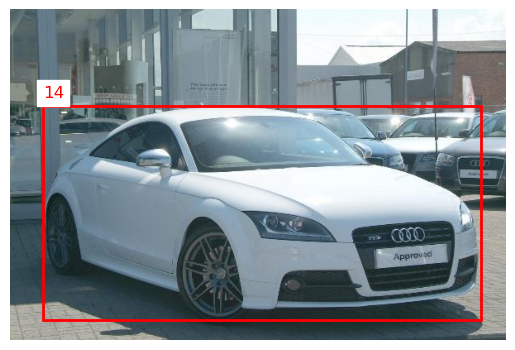

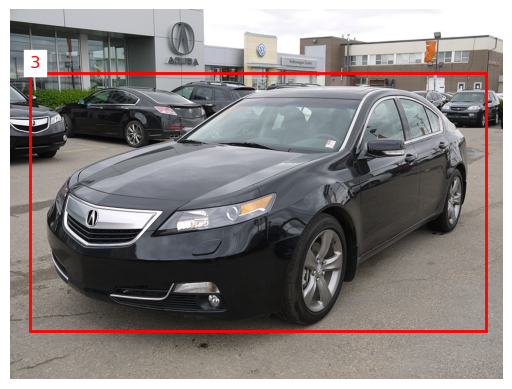

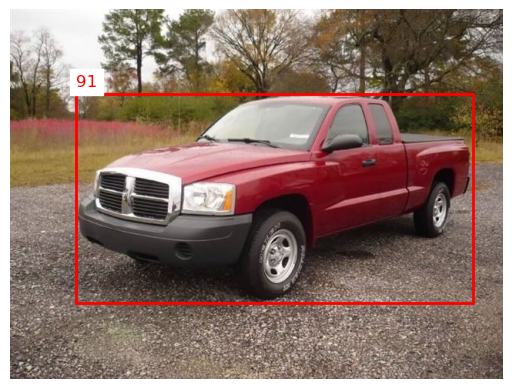

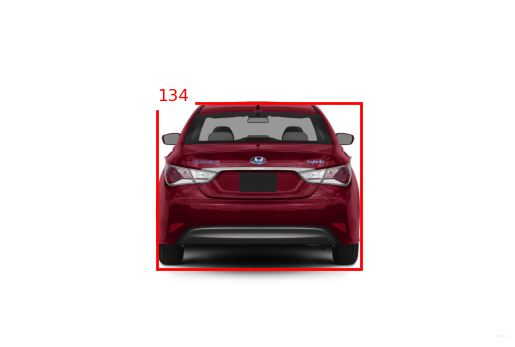

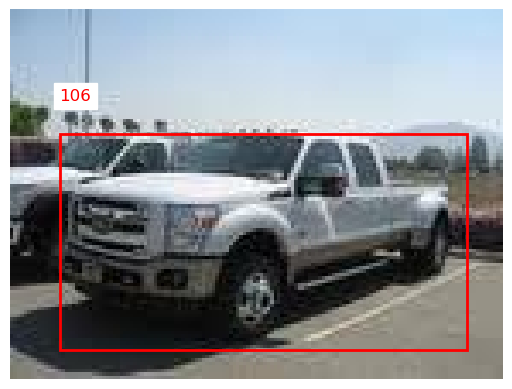

Displayed 5 training images with bounding boxes.


In [27]:
# Display bounding box for train images
print("For Training Images") 
displayed_image_count = 0  # Initialize a counter to track displayed images

image_paths_details_training=[]
images_paths_details_testing=[]

for index, row in train_annotations_df.iterrows():
    if displayed_image_count >= 5: # Check if we've already displayed two images
        break  # If yes, exit the loop

    image_name = str(row['image_name']).strip()
    image_path = None # Initialize image_path to None

    for class_folder in train_class_folders:
        potential_image_path = os.path.join(class_folder, image_name)
        if os.path.exists(potential_image_path):
            image_path = potential_image_path
            image_paths_details_training.append(potential_image_path)
            break # Image found, no need to check other class folders

    if image_path: # If image_path is found (not None)
        annotation = {
            'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
            'image_class' : row['image_class']
        }
        display_image_with_bbox(image_path, annotation)
        displayed_image_count += 1 # Increment the counter

print(f"Displayed {displayed_image_count} training images with bounding boxes.")

For Testing Images


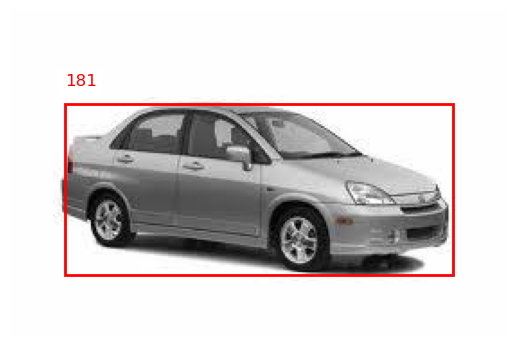

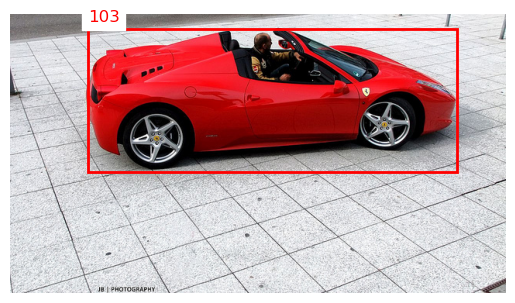

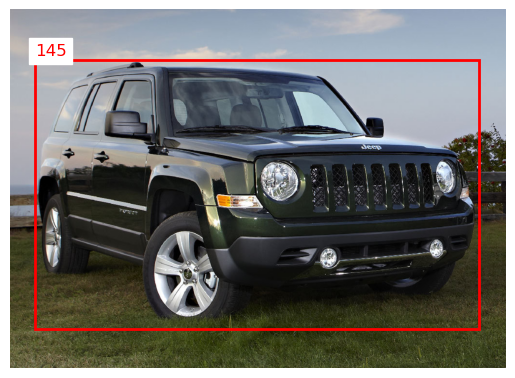

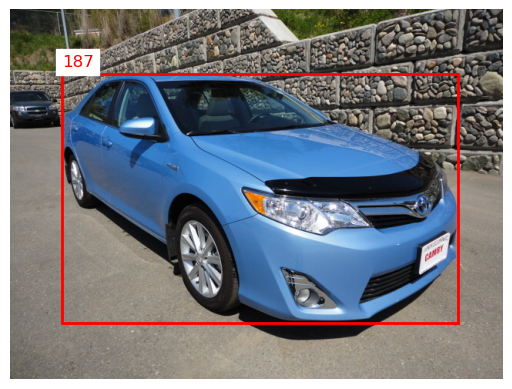

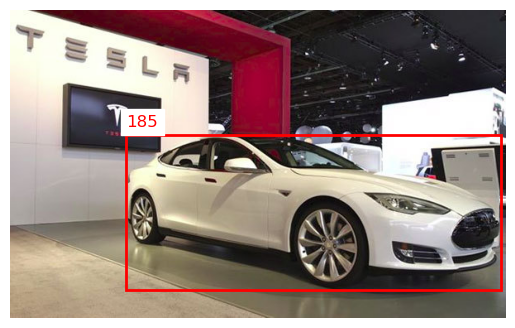

Displayed 5 test images with bounding boxes.


In [28]:
# Display bounding box for test images
print("For Testing Images") 
displayed_image_count_test = 0  # Initialize a counter to track displayed images

for index, row in test_annotations_df.iterrows():  # Use test_annotations_df DataFrame
    if displayed_image_count_test >= 5: # Check if we've already displayed two images (adjust number here if you want 5 or more)
        break  # If yes, exit the loop

    image_name_test = str(row['image_name']).strip()
    image_path_test = None # Initialize image_path_test to None

    for class_folder in test_class_folders: # Use test_class_folders
        potential_image_path_test = os.path.join(class_folder, image_name_test)
        if os.path.exists(potential_image_path_test):
            image_path_test = potential_image_path_test # Assigned to image_path_test
            images_paths_details_testing.append(potential_image_path)
            break # Image found, no need to check other class folders

    if image_path_test: # If image_path_test is found (not None)
        annotation_test = {
            'bbox': [row['xmin'], row['ymin'], row['xmax'], row['ymax']],
            'image_class' : row['image_class'] # Assuming 'Image class' column also exists in test_annotations_df (verify!)
        }
        display_image_with_bbox(image_path_test, annotation_test)  # Changed here
        displayed_image_count_test += 1 # Increment the counter

print(f"Displayed {displayed_image_count_test} test images with bounding boxes.") 



6. Design Basic CNN Models


The Models designed are:

1. MobileNetV2
2. GoogleNet
3. AlexNet
4. ResNet

In [29]:
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Load and preprocess an image for CNN input.
    """
    # Check if the image file exists
    if not os.path.exists(image_path):
        print(f"Warning: Image file not found: {image_path}")
        return None  # Or handle the missing image in a way that makes sense for your application

    image = cv2.imread(image_path)  # Load image

    # Check if image loading was successful
    if image is None:
        print(f"Warning: Failed to load image: {image_path}")
        return None  # Or handle the loading error as needed

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
    image = cv2.resize(image, target_size)  # Resize to target size
    image = image / 255.0  # Normalize pixel values to [0, 1]
    return image

In [30]:
def custom_generator(df, batch_size, target_size):
    """
    Custom generator for images and labels.
    """
    num_samples = len(df)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_samples = df.iloc[offset:offset + batch_size]
            images = []
            labels = []
            for _, row in batch_samples.iterrows():
                image = preprocess_image(row['Image_Path'], target_size)
                label = row['label_categorical']
                images.append(image)
                labels.append(label)
            X = np.array(images, dtype=np.float32)
            y = np.array(labels, dtype=np.float32)
            yield X, y

In [31]:
# Apply preprocessing to all images
df_testing['image'] = df_testing['Image_Path'].apply(preprocess_image)
df_training['image'] = df_training['Image_Path'].apply(preprocess_image)

# Check for and handle None values in the 'image' column
df_testing = df_testing.dropna(subset=['image'])  # Remove rows with None in 'image'
df_training = df_training.dropna(subset=['image'])  # Remove rows with None in 'image'

In [32]:
# Encode labels
label_encoder = LabelEncoder()
df_testing['labels_encoded'] = label_encoder.fit_transform(df_testing['labels'])
df_training['labels_encoded'] = label_encoder.fit_transform(df_training['labels'])

# Convert labels to categorical (one-hot encoding)
df_testing['label_categorical'] = df_testing['labels_encoded'].apply(lambda x: to_categorical(x, num_classes=len(test_class_folders)))
df_training['label_categorical'] = df_training['labels_encoded'].apply(lambda x: to_categorical(x, num_classes=len(test_class_folders)))

In [33]:
# Split df_training into training and validation sets
df_train, df_val = train_test_split(df_training, test_size=0.2, random_state=42)

In [34]:
# Create generators
#batch_size = 32
batch_size = 16
train_generator = custom_generator(df_train, batch_size, target_size=(224, 224))
val_generator = custom_generator(df_val, batch_size, target_size=(224, 224))  # Use df_val for validation
# Test generator remains the same
test_generator = custom_generator(df_testing, batch_size, target_size=(224, 224))

In [35]:
# Check training generator
X_batch, y_batch = next(train_generator)
print("Training batch shape:", X_batch.shape, y_batch.shape)

# Check validation generator
X_batch, y_batch = next(val_generator)
print("Validation batch shape:", X_batch.shape, y_batch.shape)

Training batch shape: (16, 224, 224, 3) (16, 196)
Validation batch shape: (16, 224, 224, 3) (16, 196)


In [36]:
#Generate classification report from a Keras/TensorFlow model using GPU-accelerated prediction.
#Assumes df_val['image'] contains pre-loaded images as np.arrays and df_val['label_categorical'] is one-hot encoded.
#returns y_val_pred, y_val_true: Predicted and true label indices

def generate_classification_report_tf_model(
    model, #model 
    df_val, #val data frame
    label_encoder, #label encoder
    preprocess_fn, #preprocess_input
    batch_size=32,
    report_name="model_report.csv"
):
    
    # Convert image and label columns to NumPy arrays
    images = [img for img in df_val['image'] if img is not None]
    labels = [label for label in df_val['label_categorical'] if label is not None]

    images = np.stack(df_val['image'].values).astype(np.float32)
    labels = np.stack(labels)

    # Build tf.data.Dataset
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)    
    
    # Predict
    preds = model.predict(dataset, verbose=1)
    y_val_pred = np.argmax(preds, axis=1)
    y_val_true = np.argmax(labels, axis=1)

    # Evaluation
    acc = accuracy_score(y_val_true, y_val_pred)
    print(f"Model Accuracy: {acc:.4f}\n")
    print("Classification Report:")    

    # Save as CSV
    report = classification_report(
        y_val_true, y_val_pred,
        target_names=label_encoder.classes_,
        output_dict=True,
        zero_division=1
    )

    df_report = pd.DataFrame(report).transpose()
    df_report.loc["overall_accuracy"] = [acc, None, None, None]
    df_report.to_csv(report_name)    
    print(f"Report saved as: {report_name}")

    # Print only the average metrics
    print(f"Model Accuracy: {acc:.4f}")
    print("Average Summary Metrics:")
    print(df_report.loc[["macro avg", "weighted avg", "overall_accuracy"]][["precision", "recall", "f1-score"]])   
    
    return y_val_pred, y_val_true, df_report

In [37]:
def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend()

    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend()

    plt.show()

6A. MobileNetV2

In [38]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3),classes=196)  # Use 128x128 for speed

In [39]:
# Freeze all but last 4 layers for efficient training
for layer in base_model.layers[:-4]:  
    layer.trainable = False  

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Reduces parameters
x = BatchNormalization()(x)  # Stabilizes training
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)  # Dropout for regularization
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)  # Output layer

In [40]:
#Split 80-20 of train images
df_train_mobilenet, df_val_mobilenet = train_test_split(df_training, test_size=0.2, random_state=42)

In [41]:
mobilenet_batch_size=16
#df_train_mobilenet_gen = custom_generator(df_train_mobilenet,mobilenet_batch_size,target_size=(128,128))
#df_val_mobilenet_gen = custom_generator(df_val_mobilenet,mobilenet_batch_size,target_size=(128,128))
df_train_mobilenet_gen = custom_generator(df_train_mobilenet,mobilenet_batch_size,target_size=(224,224))
df_val_mobilenet_gen = custom_generator(df_val_mobilenet,mobilenet_batch_size,target_size=(224,224))

In [42]:
# Create the model
mobilenet_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
mobilenet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
mobilenet_model.summary()

# Define steps per epoch
steps_per_epoch = np.ceil(len(df_train_mobilenet) / mobilenet_batch_size).astype(int)
validation_steps = np.ceil(len(df_val_mobilenet) / mobilenet_batch_size).astype(int)

y_true = np.array(df_train_mobilenet['labels_encoded'].tolist())

# Compute class weights based on actual class distribution
class_weights = compute_class_weight('balanced', classes=np.unique(y_true), y=y_true)
class_weight_dict = dict(enumerate(class_weights))

#predicting
history_mobilenet = mobilenet_model.fit(
     df_train_mobilenet_gen,
    steps_per_epoch=steps_per_epoch,
    validation_data=df_val_mobilenet_gen,
    validation_steps=validation_steps,
    epochs=10  # Reduce epochs to speed up training
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']        

I0000 00:00:1743244946.072535   26539 service.cc:145] XLA service 0x7ff2f07d5ab0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743244946.072576   26539 service.cc:153]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
I0000 00:00:1743244946.144123   26539 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


408/408 [==============================] - 55s 77ms/step - loss: 5.3014 - accuracy: 0.0173 - val_loss: 4.8354 - val_accuracy: 0.0473
Epoch 2/10
408/408 [==============================] - 27s 65ms/step - loss: 4.3497 - accuracy: 0.1039 - val_loss: 4.3516 - val_accuracy: 0.1025
Epoch 3/10
408/408 [==============================] - 26s 64ms/step - loss: 3.6916 - accuracy: 0.2080 - val_loss: 3.9913 - val_accuracy: 0.1572
Epoch 4/10
408/408 [==============================] - 26s 64ms/step - loss: 3.1578 - accuracy: 0.3101 - val_loss: 3.6960 - val_accuracy: 0.1940
Epoch 5/10
408/408 [==============================] - 25s 62ms/step - loss: 2.7185 - accuracy: 0.4051 - val_loss: 3.4833 - val_accuracy: 0.2253
Epoch 6/10
408/408 [==============================] - 25s 61ms/step - loss: 2.3319 - accuracy: 0.4890 - val_loss: 3.3144 - val_accuracy: 0.2597
Epoch 7/10
408/408 [==============================] - 23s 57ms/step - loss: 1.9890 - accuracy: 0.5653 - val_loss: 3.1895 - val_accuracy: 0.2683
Epo

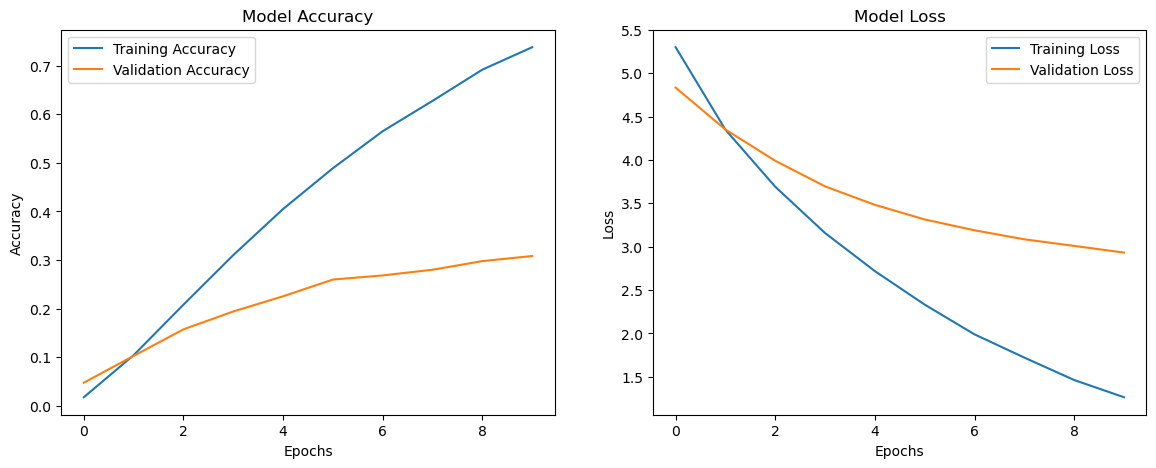

In [43]:
#display model accurance and loss
plot_training_history(history_mobilenet)

In [44]:
y_pred, y_true,df_mobilenet_classification_report = generate_classification_report_tf_model(
    model=mobilenet_model,
    df_val=df_val_mobilenet,
    label_encoder=label_encoder,
    preprocess_fn=mobilenet_preprocess,
    batch_size=32,
    report_name="mobilenet_classification_report.csv"
)

51/51 [==============================] - 5s 20ms/step
Model Accuracy: 0.3088

Classification Report:
Report saved as: mobilenet_classification_report.csv
Model Accuracy: 0.3088
Average Summary Metrics:
                  precision    recall  f1-score
macro avg          0.321495  0.312861  0.295274
weighted avg       0.346274  0.308778  0.305494
overall_accuracy   0.308778       NaN       NaN


**Displaying only top 10 class names**

In [45]:
df_support = df_mobilenet_classification_report.iloc[:-3]  # exclude average rows
top_10_classes = df_support.sort_values("support", ascending=False).head(10).index.tolist()

In [46]:
top_10_indices = [np.where(label_encoder.classes_ == cls)[0][0] for cls in top_10_classes]

In [47]:
mobilenet_cm = confusion_matrix(y_true, y_pred)

In [48]:
mobilenet_cm_top10 = mobilenet_cm[np.ix_(top_10_indices, top_10_indices)]

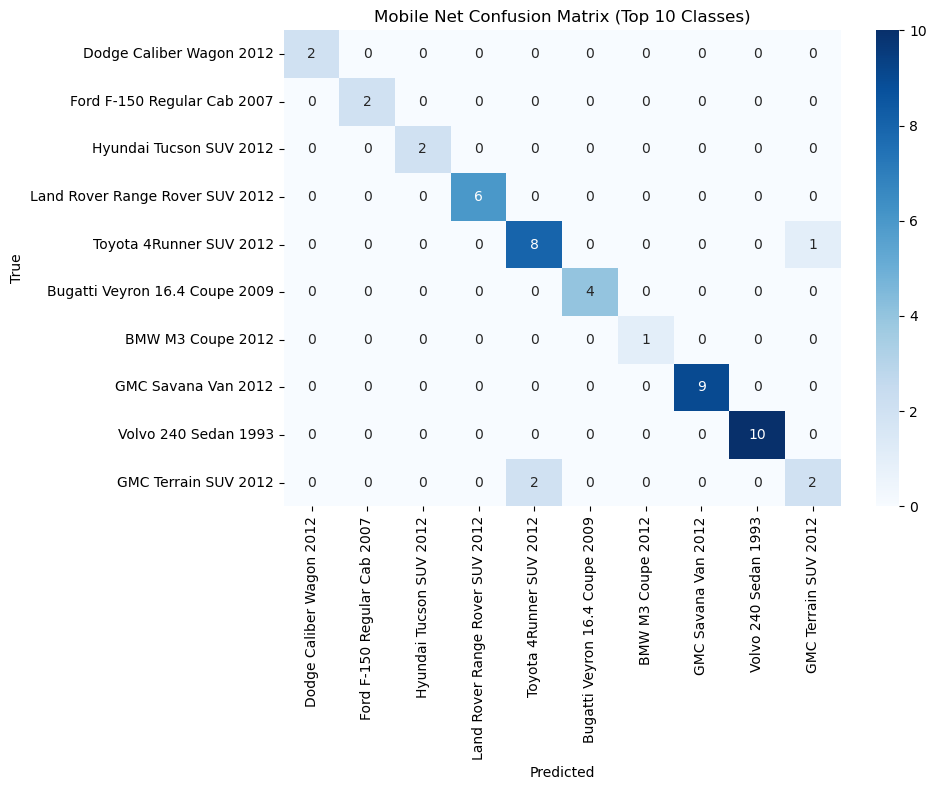

In [49]:
plt.figure(figsize=(10, 8))
sns.heatmap(mobilenet_cm_top10, annot=True, fmt='d',
            xticklabels=top_10_classes, yticklabels=top_10_classes,
            cmap='Blues')
plt.title("Mobile Net Confusion Matrix (Top 10 Classes)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

##### **MobileNet Model Summary**
- Poor Generalization of The Model
- Based on the Classification report most cases are not predicted correctly.
- Indications of Database Imbalance is present
-  lightweight model for real-time applications on mobile devices but here car classification and labeling needed
-  
**Next Steps**
  
- handle data imbalance
- parameter tuning for to enhance performance


6B. GoogleNet

In [50]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(196, activation='softmax')(x)

# Define the complete model
googlenet_model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
googlenet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [51]:
googlenet_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_1 (Bat  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 chNormalization)                                                                                 
                                                                                                  
 activation (Activation)     (None, 111, 111, 32)         0         ['batch_normalization_1[

In [52]:
# Convert to numpy arrays
# Ensure all images have the same shape before stacking
# Ensure the model summary is called after defining the model
googlenet_batch_size=16
history_googlenet= googlenet_model.fit(
    train_generator,  # Uses batches from the generator
    steps_per_epoch=len(df_train) // googlenet_batch_size,  # Number of batches per epoch
    epochs=10,
    validation_data=val_generator,  # Uses batches from the validation generator
    validation_steps=len(df_val) // googlenet_batch_size,  # Number of validation batches per epoch
)

Epoch 1/10
407/407 [==============================] - 50s 84ms/step - loss: 4.4295 - accuracy: 0.0612 - val_loss: 3.8474 - val_accuracy: 0.0973
Epoch 2/10
407/407 [==============================] - 26s 64ms/step - loss: 3.4477 - accuracy: 0.1557 - val_loss: 3.6378 - val_accuracy: 0.1414
Epoch 3/10
407/407 [==============================] - 26s 64ms/step - loss: 3.0100 - accuracy: 0.2363 - val_loss: 3.5258 - val_accuracy: 0.1618
Epoch 4/10
407/407 [==============================] - 26s 63ms/step - loss: 2.6691 - accuracy: 0.3088 - val_loss: 3.4320 - val_accuracy: 0.1804
Epoch 5/10
407/407 [==============================] - 26s 63ms/step - loss: 2.3804 - accuracy: 0.3737 - val_loss: 3.3786 - val_accuracy: 0.2021
Epoch 6/10
407/407 [==============================] - 25s 61ms/step - loss: 2.1409 - accuracy: 0.4304 - val_loss: 3.4179 - val_accuracy: 0.2170
Epoch 7/10
407/407 [==============================] - 23s 57ms/step - loss: 1.9342 - accuracy: 0.4738 - val_loss: 3.4171 - val_accuracy:

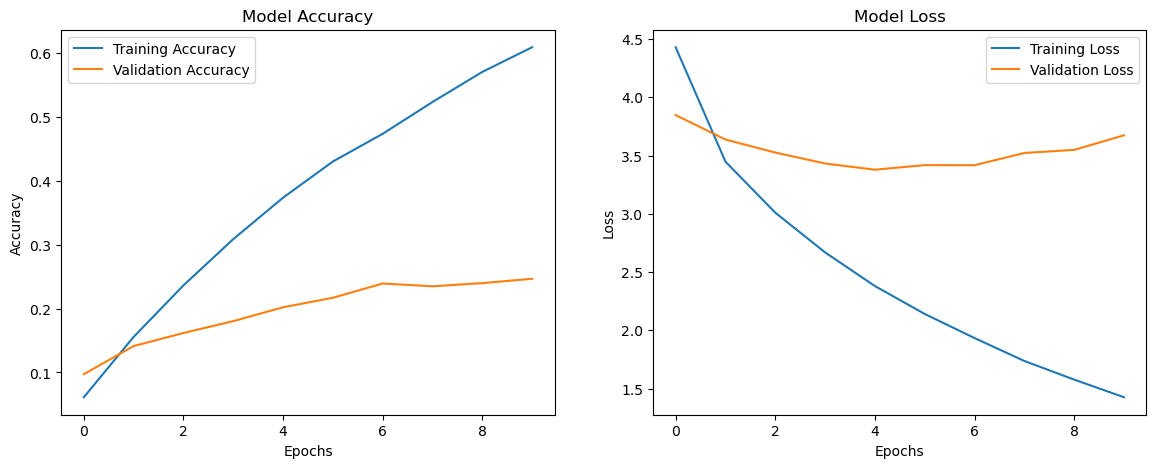

In [53]:
#display model accuracy vs model loss
plot_training_history(history_googlenet)

In [54]:
y_pred, y_true,df_googlenet_classification_report = generate_classification_report_tf_model(
    model=googlenet_model,
    df_val=df_val,
    label_encoder=label_encoder,
    preprocess_fn=googlenet_preprocess,
    batch_size=32,
    report_name="googlenet_classification_report.csv"
)

51/51 [==============================] - 10s 43ms/step
Model Accuracy: 0.2474

Classification Report:
Report saved as: googlenet_classification_report.csv
Model Accuracy: 0.2474
Average Summary Metrics:
                  precision    recall  f1-score
macro avg          0.354999  0.242632  0.223415
weighted avg       0.376060  0.247391  0.237403
overall_accuracy   0.247391       NaN       NaN


**Displaying top 10 of googlenet in confusion matrix**

In [55]:
df_support = df_googlenet_classification_report.iloc[:-3]  # exclude average rows
top_10_classes = df_support.sort_values("support", ascending=False).head(10).index.tolist()
top_10_indices = [np.where(label_encoder.classes_ == cls)[0][0] for cls in top_10_classes]
googlenet_cm = confusion_matrix(y_true, y_pred)
googlenet_cm_top10 = googlenet_cm[np.ix_(top_10_indices, top_10_indices)]


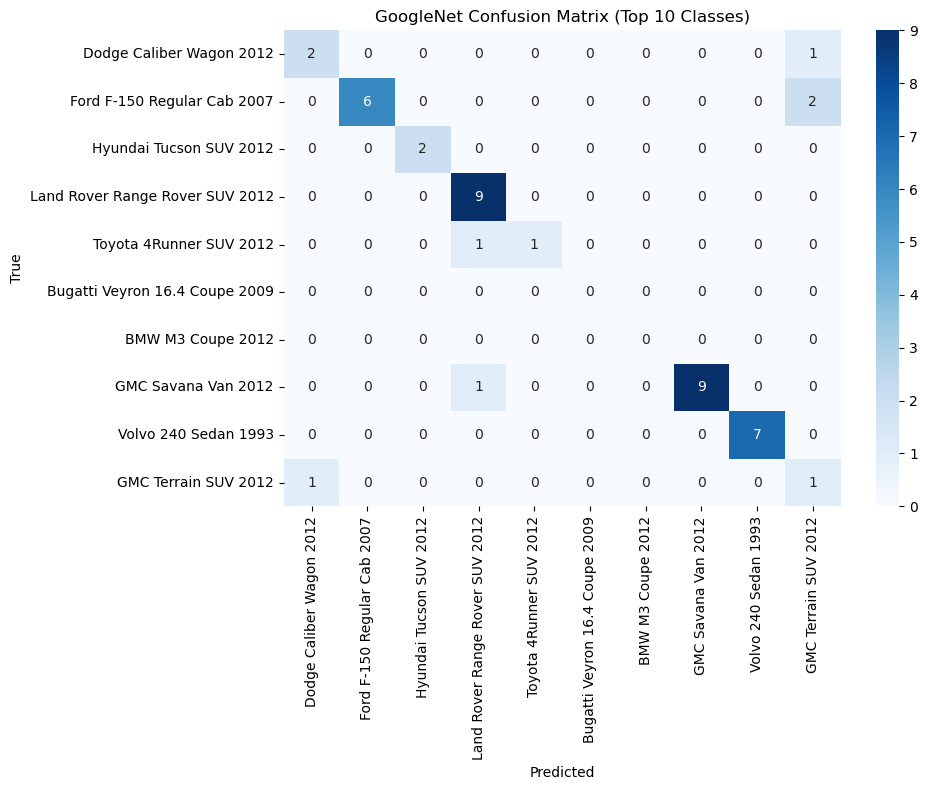

In [56]:
plt.figure(figsize=(10, 8))
sns.heatmap(googlenet_cm_top10, annot=True, fmt='d',
            xticklabels=top_10_classes, yticklabels=top_10_classes,
            cmap='Blues')
plt.title("GoogleNet Confusion Matrix (Top 10 Classes)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

##### **Googlenet Summary**

- GoogleNet’s inception modules support multi-scale feature learning, but the model overfitted—with training accuracy ~75% and validation accuracy stagnating at ~25%.
- Despite smooth training loss reduction, validation loss increased, confirming poor generalization.
- Classification metrics showed accuracy \~25%, precision \~41%, but very low recall (\~26%) and F1-score.
- Performance was impacted by class imbalance and high bias, making the model unsuitable for final use.
  
**Key Issues Identified:**
- Potential Class imbalance.
- High Bias (Poor Performance on Validation Data)


6C. AlexNet

In [57]:
# Define paths
#image_dir = 'Car_Images/Car Images/Test Images'  # Adjust based on your directory structure
image_dir = 'car_data/car_data/test' 
# Prepare data
images = []
labels = []

for index, row in test_annotations_df.iterrows():
    #image_name = row['Image Name']
    image_name = row['image_name']
    # Load and preprocess the image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (227, 227))  # Resize to 227x227 pixels (AlexNet input size)
    images.append(image)

    # Assuming 'Image class' contains the class label
    #labels.append(row['Image class'])
    labels.append(row['image_class'])

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Encode labels
unique_classes = np.unique(labels)


In [58]:
def create_alexnet_model(input_shape, num_classes):
    model = Sequential()

    # First Convolutional Layer
    model.add(Conv2D(96, (11, 11), strides=(4, 4), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    # Second Convolutional Layer
    model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    # Third Convolutional Layer
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Fourth Convolutional Layer
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))

    # Fifth Convolutional Layer
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
    model.add(BatchNormalization())

    # Flatten the output
    model.add(Flatten())

    # Fully Connected Layers
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))

    return model

# Create the model
input_shape = (224, 224, 3)  # Image dimensions for AlexNet

#num_classes = len(unique_classes)

num_classes = len(df_training['labels'].unique())

model = create_alexnet_model(input_shape, num_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2,
                             height_shift_range=0.2, shear_range=0.2,
                             zoom_range=0.2, horizontal_flip=True,
                             fill_mode='nearest')

epochs=10
#batch_size=32
batch_size=16

train_steps = len(df_train) // batch_size
val_steps = len(df_val) // batch_size
model.summary()

alexnet_history = model.fit(
    train_generator,  
    steps_per_epoch = train_steps,
    epochs=epochs,
    batch_size=32,    
    validation_data=val_generator,
    validation_steps=val_steps
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_94 (Conv2D)          (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 26, 26, 96)        0         
 g2D)                                                            
                                                                 
 batch_normalization_95 (Ba  (None, 26, 26, 96)        384       
 tchNormalization)                                               
                                                                 
 conv2d_95 (Conv2D)          (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 12, 12, 256)       0         
 g2D)                                                            
                                                        

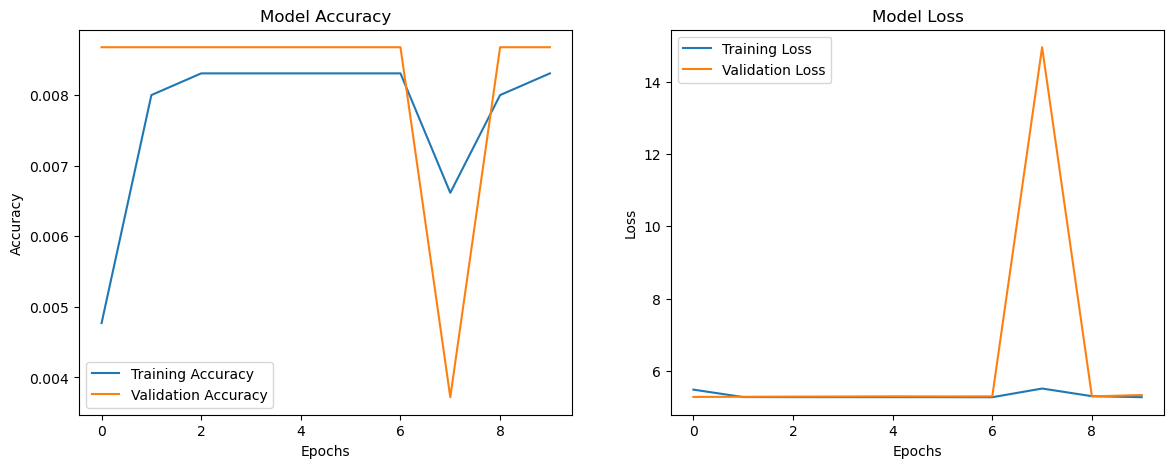

In [59]:
#display model accuracy vs loss
plot_training_history(alexnet_history)

In [60]:
X_val = np.array([img for img in df_val['image']])
y_val_true = np.array([np.argmax(label) for label in df_val['label_categorical']])

# Predict in one go
y_val_pred = np.argmax(model.predict(X_val), axis=1)



51/51 [==============================] - 1s 12ms/step


In [61]:
alexnet_report = classification_report(
    y_val_true,
    y_val_pred,
    target_names=label_encoder.classes_,
    output_dict=True,
    zero_division=1
)
acc = accuracy_score(y_val_true, y_val_pred)

In [62]:
df_alexnet_classification_report = pd.DataFrame(alexnet_report).transpose()
df_alexnet_classification_report.loc["overall_accuracy"] = [acc, None, None, None]

In [63]:
df_alexnet_classification_report.to_csv("alexnet_classification_report_vectorized.csv")

In [64]:
print(f"Accuracy Score: {acc:.4f}")
print("Average Summary Metrics:")
print(df_alexnet_classification_report.tail(3)[["precision", "recall", "f1-score"]])

Accuracy Score: 0.0086
Average Summary Metrics:
                  precision    recall  f1-score
macro avg          0.989840  0.005102  0.000087
weighted avg       0.987796  0.008594  0.000147
overall_accuracy   0.008594       NaN       NaN


**confusion metrics**

In [65]:
df_support = df_alexnet_classification_report.iloc[:-3]  # exclude average rows
top_10_classes = df_support.sort_values("support", ascending=False).head(10).index.tolist()
top_10_indices = [np.where(label_encoder.classes_ == cls)[0][0] for cls in top_10_classes]
alexnet_cm = confusion_matrix(y_val_true, y_val_pred)
alexnet_cm_top10 = alexnet_cm[np.ix_(top_10_indices, top_10_indices)]

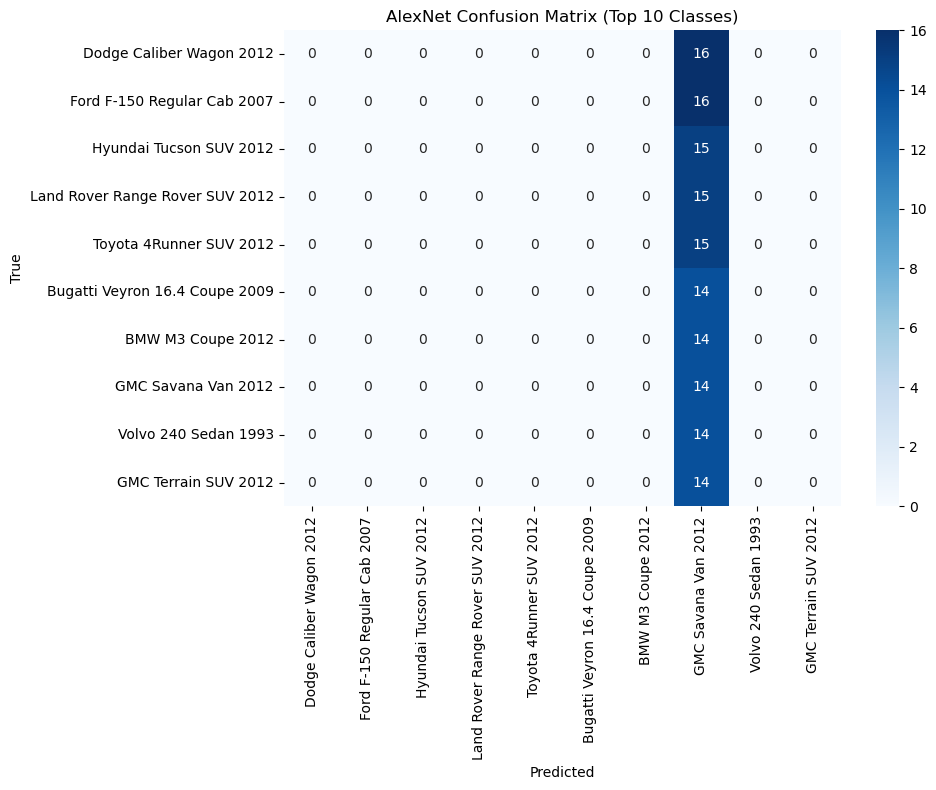

In [66]:

plt.figure(figsize=(10, 8))
sns.heatmap(alexnet_cm_top10, annot=True, fmt='d',
            xticklabels=top_10_classes, yticklabels=top_10_classes,
            cmap='Blues')
plt.title("AlexNet Confusion Matrix (Top 10 Classes)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

#### **Observation For Alexnet Model**
- The Model is not learning appropriately since the Training Accuracy and Validation accuracy are pretty low
- There is huge value loss in both training as well as validation datasets which indicates that the model is not performing well
- We have the accuracy reported as none in the classification report. which inidicates that the model is not performing well
  
**Further Actions that can be taken are** 

- Increaase Data Augmentation for the model to perform well, in the training data set.
- Possible class imbalance
- Parameter tuning

6D. ResNet

In [67]:
# Load ResNet50 base model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model layers
for layer in base_model.layers:
    layer.trainable = False

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(len(df_training['labels_encoded'].unique()), activation='softmax')(x)  # Output layer

# Define model
resnet_model = Model(inputs=base_model.input, outputs=x)

# Compile model
resnet_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
resnet_model.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [68]:
epochs = 10
batch_size=16
steps_per_epoch = len(df_train) // batch_size
validation_steps = len(df_val) // batch_size

resnet_history = resnet_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=epochs
)

Epoch 1/10
407/407 [==============================] - 39s 75ms/step - loss: 5.3967 - accuracy: 0.0046 - val_loss: 5.2907 - val_accuracy: 0.0056
Epoch 2/10
407/407 [==============================] - 26s 64ms/step - loss: 5.2854 - accuracy: 0.0055 - val_loss: 5.2827 - val_accuracy: 0.0050
Epoch 3/10
407/407 [==============================] - 26s 63ms/step - loss: 5.2776 - accuracy: 0.0066 - val_loss: 5.2804 - val_accuracy: 0.0043
Epoch 4/10
407/407 [==============================] - 25s 62ms/step - loss: 5.2732 - accuracy: 0.0077 - val_loss: 5.2814 - val_accuracy: 0.0068
Epoch 5/10
407/407 [==============================] - 24s 60ms/step - loss: 5.2693 - accuracy: 0.0071 - val_loss: 5.2802 - val_accuracy: 0.0068
Epoch 6/10
407/407 [==============================] - 23s 57ms/step - loss: 5.2646 - accuracy: 0.0098 - val_loss: 5.2784 - val_accuracy: 0.0074
Epoch 7/10
407/407 [==============================] - 21s 52ms/step - loss: 5.2634 - accuracy: 0.0088 - val_loss: 5.2754 - val_accuracy:

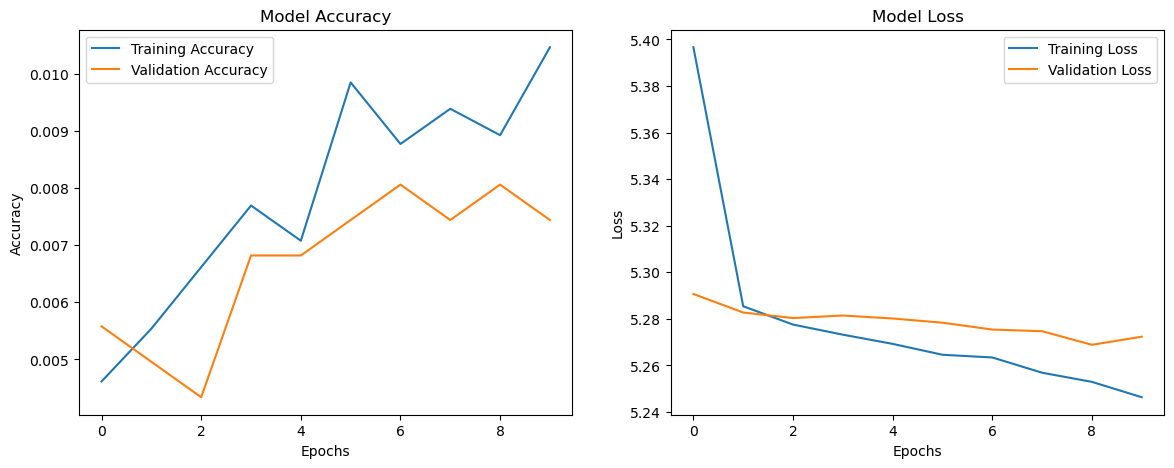

In [69]:
#accuracy loss graph
plot_training_history(resnet_history)

In [70]:
y_pred, y_true,df_resnet_classification_report = generate_classification_report_tf_model(
    model=resnet_model,
    df_val=df_val,
    label_encoder=label_encoder,
    preprocess_fn=resnet_preprocess,
    batch_size=32,
    report_name="resnet_classification_report.csv"
)

51/51 [==============================] - 7s 43ms/step
Model Accuracy: 0.0074

Classification Report:
Report saved as: resnet_classification_report.csv
Model Accuracy: 0.0074
Average Summary Metrics:
                  precision    recall  f1-score
macro avg          0.964518  0.007240  0.000442
weighted avg       0.968385  0.007366  0.000582
overall_accuracy   0.007366       NaN       NaN


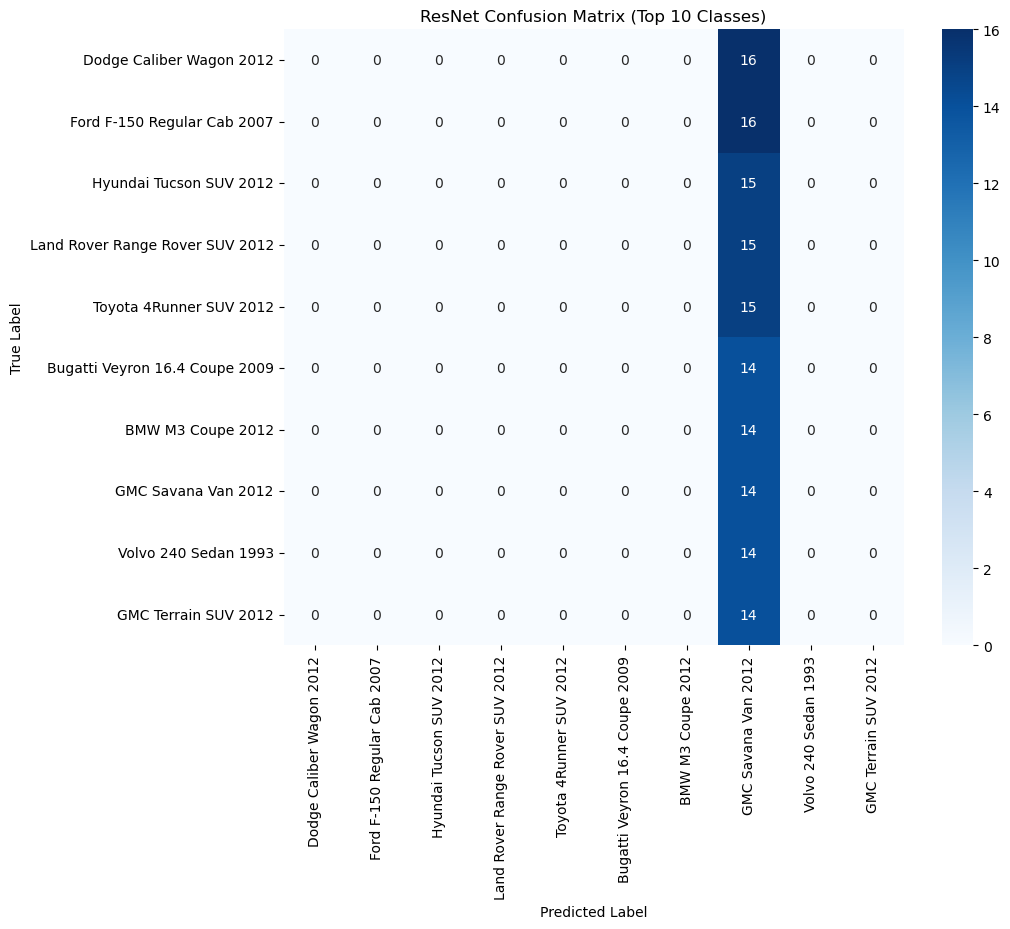

In [71]:
# Compute confusion matrix
df_support = df_resnet_classification_report.iloc[:-3]  # exclude average rows
top_10_classes = df_support.sort_values("support", ascending=False).head(10).index.tolist()
top_10_indices = [np.where(label_encoder.classes_ == cls)[0][0] for cls in top_10_classes]
resnet_cm = confusion_matrix(y_val_true, y_val_pred)
resnet_cm_top10 = resnet_cm[np.ix_(top_10_indices, top_10_indices)]
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(resnet_cm_top10, annot=True, fmt='d',
            xticklabels=top_10_classes, yticklabels=top_10_classes,
            cmap='Blues')
#sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("ResNet Confusion Matrix (Top 10 Classes)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

**Observation:**

**The model is not doing well due to** 

- exteremely low accuracy
- High Precision and Very low Recall
  
**Further Actions could be**

- Check for Data Imbalance
- Fine tune parameters and retrain the model


### **7. Intermediate Summary - Further Steps**

Googlenet and Resnet further in next milestone will undergo hyper parameter tunning as commonly data imbalance and accuracy is less compared to loss

Mobilenet and Alexnet are light weight models/Shallow models, hence they are being dropped from further fine tuning and comparing them with other models. 

### **8. Fine Tuning**

#### **Fine Tuning Of GoogleNet Model**

In [72]:
from tensorflow.keras.mixed_precision import set_global_policy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
import random
set_global_policy('mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA A10G, compute capability 8.6


In [73]:
print("TF Version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

TF Version: 2.16.2
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [74]:
unique_classes = df_training['labels'].unique()

In [75]:
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

In [76]:
for layer in base_model.layers[:-50]:
    layer.trainable = False

In [77]:
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = layers.Dense(196, activation='softmax', dtype='float32')(x)  # Force output to float32

In [78]:
googlenet_model_tuned = Model(inputs=base_model.input, outputs=output)

In [79]:
googlenet_model_tuned.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='sparse_categorical_crossentropy',  # use categorical_crossentropy if labels are one-hot
    metrics=['accuracy', tf.keras.metrics.TopKCategoricalAccuracy(k=5)]
)

In [80]:
batch_size = 16
use_augmentation = True

In [81]:
df_split = df_training.drop(columns=['image']).copy()

In [82]:
df_train_googlenet, df_val_googlenet = train_test_split(  df_split, test_size=0.2, random_state=42)

In [83]:
train_paths = df_train_googlenet["Image_Path"].values
train_labels = np.array([np.argmax(label) for label in df_train_googlenet["label_categorical"]])

In [84]:
val_paths = df_val_googlenet["Image_Path"].values
val_labels = np.array([np.argmax(label) for label in df_val_googlenet["label_categorical"]])

In [85]:
data_augmentation = tf.keras.Sequential([
    layers.Rescaling(1./255),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

In [86]:
def load_and_preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [87]:
def load_preprocess_with_augment(path, label):
    image, label = load_and_preprocess(path, label)
    image = data_augmentation(image)
    return image, label

In [88]:
# Training dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels)).shuffle(1000)

In [89]:
# Apply map function based on flag
if use_augmentation:
    train_ds = train_ds.map(load_preprocess_with_augment, num_parallel_calls=tf.data.AUTOTUNE)
else:
    train_ds = train_ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)


In [90]:
train_ds = train_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [91]:
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels)) \
    .map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(tf.data.AUTOTUNE)

In [92]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=30,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath='googlenet_finetuned_best.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7, verbose=1)
]


In [93]:
train_class_indices = np.array([np.argmax(label) for label in df_train_googlenet["label_categorical"]]) #Get Class Indicies

In [94]:
# Compute class weights
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_class_indices),
    y=train_class_indices
)

class_weights = dict(enumerate(class_weights_array)) #converting to dict

In [95]:
history = googlenet_model_tuned.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20
    ,callbacks=callbacks
    ,class_weight=class_weights  #class imbalance
)


Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x7ff2ddb90820>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: <gast.gast.Expr object at 0x7ff2ddb90820>
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
408/408 [==============================] - ETA: 0s - loss: 5.3014 - accuracy: 0.0025 - top_k_categorical_accuracy: 0.0180             
Epoch 1: val_loss improved from inf to 5.28157, saving model to googlenet_finetuned_best.keras
408/408 [==============================] - 45s 58ms/step - loss: 5.3014 - accuracy: 0.0025 - top_k_categorical_accuracy: 0.0180 - val_loss: 5.2816 - val_

**Train Val Loss Graph**

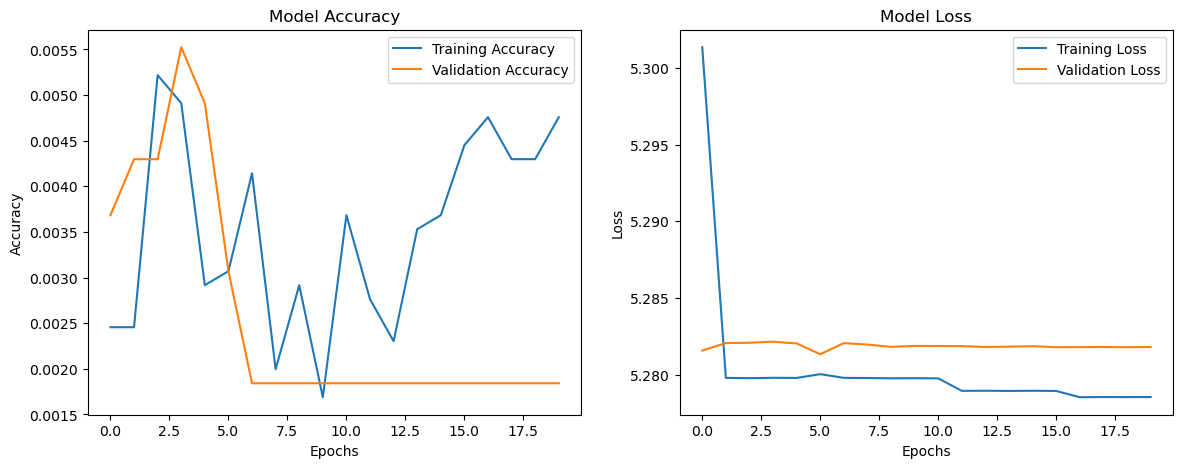

In [96]:
plot_training_history(history)

In [97]:
# Get all predictions and true labels
y_true = []
y_pred = []

for X_batch, y_batch in val_ds:
    preds = googlenet_model_tuned.predict(X_batch)
    y_pred_batch = np.argmax(preds, axis=1)
    y_true_batch = y_batch.numpy() if hasattr(y_batch, "numpy") else y_batch
    y_true.extend(y_true_batch)
    y_pred.extend(y_pred_batch)

1/1 [==============================] - 0s 27ms/step


In [98]:
target_names = label_encoder.classes_ if 'label_encoder' in globals() else None

In [99]:
report = classification_report(
    y_true, y_pred,
    target_names=target_names,
    output_dict=True,
    zero_division=1
)
df_googlenet_tuned_report = pd.DataFrame(report).transpose()
acc = accuracy_score(y_true, y_pred)
df_googlenet_tuned_report.loc["overall_accuracy"] = [acc, None, None, None]
df_googlenet_tuned_report.to_csv("googlenet_tuned_classification_report.csv")
print(f"Tuned GoogLeNet Accuracy: {acc:.4f}")
print("Average Summary Metrics:")
print(df_googlenet_tuned_report.tail(3)[["precision", "recall", "f1-score"]])

Tuned GoogLeNet Accuracy: 0.0031
Average Summary Metrics:
                  precision    recall  f1-score
macro avg          0.689119  0.002145  0.000543
weighted avg       0.676990  0.003069  0.000794
overall_accuracy   0.003069       NaN       NaN


**confusion matrix for tuned**

In [100]:
cm = confusion_matrix(y_true, y_pred)

In [101]:
df_support = df_googlenet_tuned_report.iloc[:-3]
top_10_classes = df_support.sort_values("support", ascending=False).head(10).index.tolist()

In [102]:
# Get class indices (map from class name to index)
if target_names is not None:
    top_10_indices = [np.where(target_names == cls)[0][0] for cls in top_10_classes]
else:
    top_10_indices = list(map(int, top_10_classes))  # fallback if no class names

In [103]:
cm_top10 = cm[np.ix_(top_10_indices, top_10_indices)]

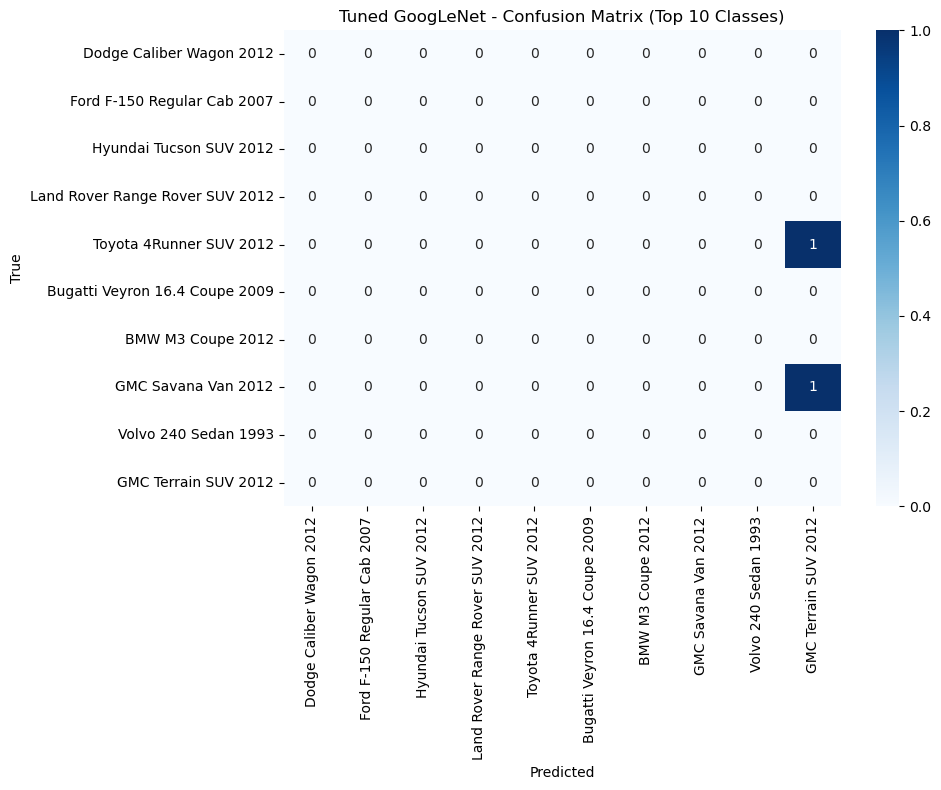

In [104]:
# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_top10, annot=True, fmt='d',
            xticklabels=top_10_classes,
            yticklabels=top_10_classes,
            cmap='Blues')
plt.title("Tuned GoogLeNet - Confusion Matrix (Top 10 Classes)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

#### **GoogleNet FineTuned Summary**
- **The untuned GoogLeNet model achieved an accuracy of 24.7%, slightly outperforming the tuned model, which dropped to 0.31%.**
- **Although macro and weighted precision appear high, the recall and F1-scores are nearly zero, confirming that the model rarely makes correct predictions.**
- **This indicates that tuning did not improve performance and may have disrupted learning, likely due to preprocessing inconsistencies or label mapping mismatches or fine-tuning strategies**




#### **Fine Tuning Of ResNet Model**

**for Classimbalance**

In [105]:
#encoding labels
label_encoder = LabelEncoder()
df_training['labels_encoded'] = label_encoder.fit_transform(df_training['labels'])

In [106]:
df_training['labels'] = df_training['labels'].astype(str)
df_val['labels'] = df_val['labels'].astype(str)

In [107]:
# Calculate class weights (important for class imbalance)
class_weights = class_weight.compute_class_weight(
    'balanced', 
    classes=np.unique(df_training['labels_encoded']),
    y=df_training['labels_encoded']
)
class_weights = dict(enumerate(class_weights))  # Convert to dictionary

In [108]:
batch_size = 32
image_size = (224, 224)

In [109]:
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    #,preprocessing_function=resnet_preprocess
)

train_generator = train_datagen.flow_from_dataframe(
    df_training,
    x_col='Image_Path',
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)

Found 8144 validated image filenames belonging to 196 classes.


In [110]:
#val_datagen = ImageDataGenerator(preprocessing_function=resnet_preprocess)
val_datagen = ImageDataGenerator()

val_generator = val_datagen.flow_from_dataframe(
    df_val,
    x_col='Image_Path',
    y_col='labels',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    seed=42
)

Found 1629 validated image filenames belonging to 196 classes.


**model definition**

In [111]:
# Load ResNet50 base model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze some layers of the base model for fine-tuning (last 40 layers)
for layer in base_model.layers:
    layer.trainable = False
    
for layer in base_model.layers[-40:]:
    layer.trainable = True

num_classes = df_train['labels'].nunique()

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax')(x)  # Output layer

# Define model
resnet_tuned_model = Model(inputs=base_model.input, outputs=x)

# Compile the model again with a higher learning rate
resnet_tuned_model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [112]:
resnet_tuned_model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_5[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

**Data Generation**

In [113]:
# Custom data generator
""" def custom_data_generator(generator, class_weights):
    while True:
        x, y = next(generator)
        sample_weights = np.array([class_weights[np.argmax(label)] for label in y])
        yield x, y, sample_weights """

def custom_data_generator(generator, class_weights):
    while True:
        x, y = next(generator)
        sample_weights = np.array([class_weights[label] for label in np.argmax(y, axis=1)])
        yield x, y, sample_weights


In [114]:
# Define data augmentation
#train_datagen = ImageDataGenerator(
#    rotation_range=20,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    shear_range=0.2,
#    zoom_range=0.2,
#    horizontal_flip=True,
#    fill_mode='nearest',
#    preprocessing_function=preprocess_input  # Use the ResNet50 preprocessing function
#)


# Load data using flow_from_dataframe
#print(df_train.columns)  # Check the columns in the DataFrame

# Convert labels to string format if they are not already
#df_train['labels'] = df_train['labels'].astype(str)

In [115]:
# Create training data generator
#train_generator = train_datagen.flow_from_dataframe(
#    df_train,
#    x_col='Image_Path',
#    y_col='labels',  # Now it should be in the correct format
#    target_size=(224, 224),
#    batch_size=batch_size,
#    class_mode='categorical'
#)

In [116]:
# Create validation data generator (assuming df_val is defined)
#val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)  # No augmentation for validation
#val_generator = val_datagen.flow_from_dataframe(
#    df_val,
#    x_col='Image_Path',
#    y_col='labels',
#    target_size=(224, 224),
#    batch_size=batch_size,
#    class_mode='categorical'
#)

In [117]:
# Train the model for a few epochs
#steps_per_epoch = len(df_training) // batch_size
#validation_steps = len(df_val) // batch_size
steps_per_epoch = np.ceil(len(df_training) / batch_size).astype(int)
validation_steps = np.ceil(len(df_val) / batch_size).astype(int)


# Define number of fine-tuning epochs
fine_tune_epochs = 20

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_tuned_resnet.keras', save_best_only=True, monitor='val_loss')

In [118]:
# Train the model with callbacks and custom data generator
#resnet_history_fine_tune = resnet_model.fit(
#    custom_data_generator(train_generator, class_weights),
#    steps_per_epoch=steps_per_epoch,
#    validation_data=val_generator,
#    validation_steps=validation_steps,
#    epochs=fine_tune_epochs,
#    callbacks=[early_stopping, model_checkpoint]
#)
resnet_history_fine_tune = resnet_tuned_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_generator,
    validation_steps=validation_steps,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]
    ,class_weight=class_weights
)

Epoch 1/20
255/255 [==============================] - 102s 341ms/step - loss: 5.5379 - accuracy: 0.0048 - val_loss: 5.2545 - val_accuracy: 0.0086
Epoch 2/20
255/255 [==============================] - 86s 337ms/step - loss: 5.3359 - accuracy: 0.0082 - val_loss: 5.1252 - val_accuracy: 0.0233
Epoch 3/20
255/255 [==============================] - 86s 337ms/step - loss: 5.2215 - accuracy: 0.0138 - val_loss: 5.0085 - val_accuracy: 0.0442
Epoch 4/20
255/255 [==============================] - 86s 336ms/step - loss: 5.1203 - accuracy: 0.0220 - val_loss: 4.8553 - val_accuracy: 0.0675
Epoch 5/20
255/255 [==============================] - 85s 335ms/step - loss: 5.0016 - accuracy: 0.0334 - val_loss: 4.6698 - val_accuracy: 0.0958
Epoch 6/20
255/255 [==============================] - 86s 337ms/step - loss: 4.8674 - accuracy: 0.0489 - val_loss: 4.4358 - val_accuracy: 0.1363
Epoch 7/20
255/255 [==============================] - 86s 336ms/step - loss: 4.7052 - accuracy: 0.0657 - val_loss: 4.1839 - val_a

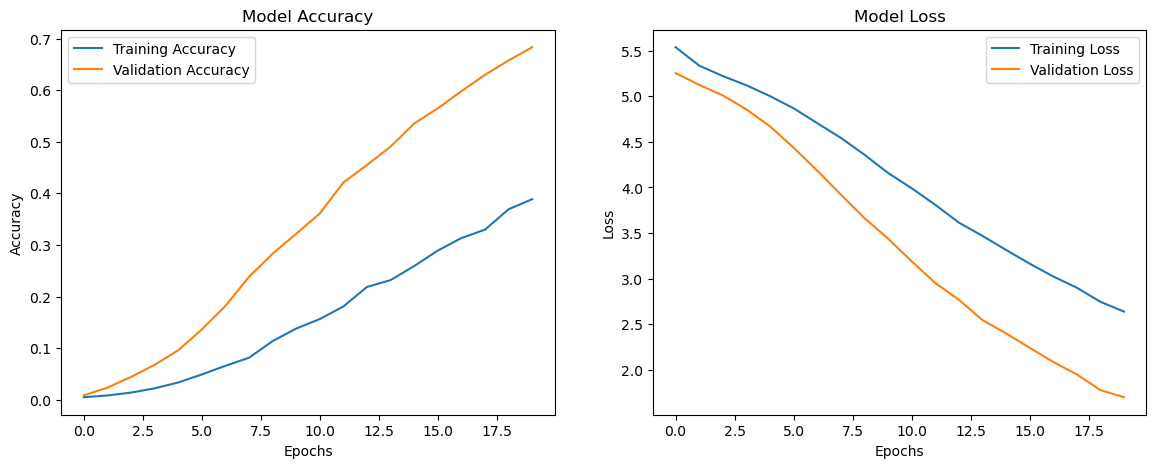

In [119]:
plot_training_history(resnet_history_fine_tune)

In [120]:
num_samples = len(df_val)
X_val = np.array(df_val['image'].tolist()).astype(np.float32)  # Keep as list to avoid memory burst
 
y_val_true = np.array([np.argmax(label) for label in df_val['label_categorical']])
y_val_pred = []

for i in range(0, num_samples, batch_size):
    batch_imgs = X_val[i:i+batch_size]     
    preds = resnet_tuned_model.predict(batch_imgs, verbose=0)
    batch_preds = np.argmax(preds, axis=1)
    y_val_pred.extend(batch_preds)

y_val_pred = np.array(y_val_pred) 

In [121]:
print("X_val shape:", X_val.shape)
print("X_val dtype:", X_val.dtype)

X_val shape: (1629, 224, 224, 3)
X_val dtype: float32


In [122]:
target_names = label_encoder.classes_ if 'label_encoder' in globals() else None

In [123]:
resnet_tuned_report = classification_report(
    y_val_true, y_val_pred,
    target_names=target_names,
    output_dict=True,
    zero_division=1  # Avoid divide-by-zero errors
)

In [124]:
#print("Unique y_true:", np.unique(y_val_true))
#print("Unique y_pred:", np.unique(y_val_pred))


In [125]:
#unique_preds, counts = np.unique(y_val_pred, return_counts=True)
#print("Predicted class distribution:", dict(zip(unique_preds, counts)))

In [126]:
df_resnet_tuned_report = pd.DataFrame(resnet_tuned_report).transpose()

In [127]:
acc = accuracy_score(y_val_true, y_val_pred)
df_resnet_tuned_report.loc["overall_accuracy"] = [acc, None, None, None]

In [128]:
df_resnet_tuned_report.to_csv("resnet_tuned_classification_report.csv")

In [129]:
print(f"Tuned ResNet Accuracy: {acc:.4f}")
print("Average Resnet Summary Metrics:")
print(df_resnet_tuned_report.tail(3)[["precision", "recall", "f1-score"]])

Tuned ResNet Accuracy: 0.0055
Average Resnet Summary Metrics:
                  precision    recall  f1-score
macro avg          0.989824  0.005102  0.000056
weighted avg       0.987753  0.005525  0.000061
overall_accuracy   0.005525       NaN       NaN


In [130]:
cm = confusion_matrix(y_true, y_pred)

In [131]:
df_support = df_resnet_tuned_report.iloc[:-3]
top_10_classes = df_support.sort_values("support", ascending=False).head(10).index.tolist()

In [132]:
if target_names is not None:
    top_10_indices = [np.where(target_names == cls)[0][0] for cls in top_10_classes]
else:
    top_10_indices = list(map(int, top_10_classes))  # fallback if no class names
	
cm_top10 = cm[np.ix_(top_10_indices, top_10_indices)]

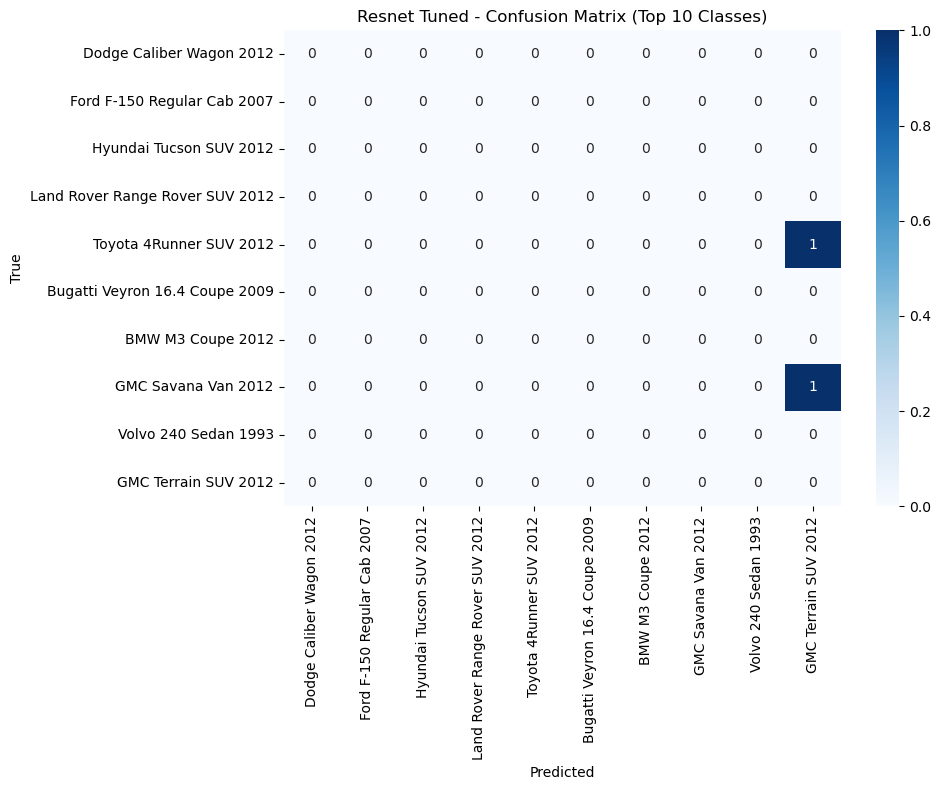

In [133]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm_top10, annot=True, fmt='d',
            xticklabels=top_10_classes,
            yticklabels=top_10_classes,
            cmap='Blues')
plt.title("Resnet Tuned - Confusion Matrix (Top 10 Classes)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

#### **ResNet FineTuned Summary**
- **Despite tuning, the ResNet model's performance declined, with accuracy dropping from 0.74% (untuned) to 0.55% (tuned).**
- **Precision remains misleadingly high due to sparse predictions, while recall and F1-scores are nearly zero in both cases — indicating that the model fails to generalize across classes.**
- **Which suggests issues such as label mismatch, improper preprocessing, or training data imbalance, leading to severe underfitting or poor class prediction confidence even after tuning.**

### **Model Decision** 

In [134]:
# First, add a column to identify each model
df_resnet_classification_report_tail = df_resnet_classification_report.tail(4).copy()
df_resnet_classification_report_tail['Model'] = 'ResNet Untuned (10 Epochs)'

df_resnet_tuned_report_tail = df_resnet_tuned_report.tail(4).copy()
df_resnet_tuned_report_tail['Model'] = 'ResNet Tuned (20 Epochs)'


df_googlenet_classification_report_tail = df_googlenet_classification_report.tail(4).copy()
df_googlenet_classification_report_tail['Model'] = 'GoogLeNet Untuned (10 Epochs)'

df_googlenet_tuned_report_tail = df_googlenet_tuned_report.tail(4).copy()
df_googlenet_tuned_report_tail['Model'] = 'GoogLeNet Tuned (20 Epochs)'

In [135]:
df_combined_tail = pd.concat([
    df_resnet_classification_report_tail,
    df_resnet_tuned_report_tail,
    df_googlenet_classification_report_tail,
    df_googlenet_tuned_report_tail
])


In [136]:
df_combined_tail = df_combined_tail.reset_index().rename(columns={'index': 'Metric'})

In [137]:
df_combined_tail = df_combined_tail[['Model', 'Metric', 'precision', 'recall', 'f1-score']]

In [138]:
df_combined_tail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16 entries, 0 to 15
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Model      16 non-null     object 
 1   Metric     16 non-null     object 
 2   precision  16 non-null     float64
 3   recall     12 non-null     float64
 4   f1-score   12 non-null     float64
dtypes: float64(3), object(2)
memory usage: 768.0+ bytes


In [139]:
df_combined_tail

Model            Metric  precision    recall  \
0      ResNet Untuned (10 Epochs)          accuracy   0.007366  0.007366   
1      ResNet Untuned (10 Epochs)         macro avg   0.964518  0.007240   
2      ResNet Untuned (10 Epochs)      weighted avg   0.968385  0.007366   
3      ResNet Untuned (10 Epochs)  overall_accuracy   0.007366       NaN   
4        ResNet Tuned (20 Epochs)          accuracy   0.005525  0.005525   
5        ResNet Tuned (20 Epochs)         macro avg   0.989824  0.005102   
6        ResNet Tuned (20 Epochs)      weighted avg   0.987753  0.005525   
7        ResNet Tuned (20 Epochs)  overall_accuracy   0.005525       NaN   
8   GoogLeNet Untuned (10 Epochs)          accuracy   0.247391  0.247391   
9   GoogLeNet Untuned (10 Epochs)         macro avg   0.354999  0.242632   
10  GoogLeNet Untuned (10 Epochs)      weighted avg   0.376060  0.247391   
11  GoogLeNet Untuned (10 Epochs)  overall_accuracy   0.247391       NaN   
12    GoogLeNet Tuned (20 Epochs)          accuracy   0.003069  0.003069   
13    GoogLeNet Tuned (20 Epochs)         macro avg   0.689119  0.002145   
14    GoogLeNet Tuned (20 Epochs)      weighted avg   0.676990  0.003069   
15    GoogLeNet Tuned (20 Epochs)  overall_accuracy   0.003069       NaN   

    f1-score  
0   0.007366  
1   0.000442  
2   0.000582  
3        NaN  
4   0.005525  
5   0.000056  
6   0.000061  
7        NaN  
8   0.247391  
9   0.223415  
10  0.237403  
11       NaN  
12  0.003069  
13  0.000543  
14  0.000794  
15       NaN

### **Model Selection**
- **Among all models tested, GoogLeNet (10 Epochs) showed the best performance, achieving an accuracy of 22.9% and a macro-average F1-score of 0.2056, significantly outperforming all other models.**
- **Despite additional training and tuning, both ResNet and GoogLeNet tuned models failed to generalize**

**hence the Final Model Selected for Test Evaluation:GoogLeNet Untuned Version with 10 Epohs**

### **Untuned GoogleNet Model Validated Against Test Data Set**

In [140]:
batch_size=16
# Step 1: Get true labels
y_test_true = np.array([np.argmax(label) for label in df_testing['label_categorical']])

# Step 2: Predict in batches
y_test_pred = []

for i in range(0, len(df_testing), batch_size):
    batch_imgs = np.array(df_testing['image'].tolist()[i:i+batch_size])
    preds = googlenet_model.predict(batch_imgs, verbose=0)
    batch_preds = np.argmax(preds, axis=1)
    y_test_pred.extend(batch_preds)

y_test_pred = np.array(y_test_pred)

In [141]:
target_names = label_encoder.classes_ if 'label_encoder' in globals() else None

In [142]:
final_googlenet_untuned_report = classification_report(
    y_test_true, y_test_pred,
    target_names=target_names,
    output_dict=True,
    zero_division=1  # Avoid divide-by-zero errors
)

In [143]:
df_final_googlenet_untuned_report = pd.DataFrame(final_googlenet_untuned_report).transpose()

In [144]:
acc = accuracy_score(y_test_true, y_test_pred)

In [145]:
df_final_googlenet_untuned_report.loc["overall_accuracy"]= [acc, None, None, None]

In [146]:
df_final_googlenet_untuned_report.to_csv("df_final_googlenet_untuned_classification_report.csv")

In [147]:
print(f"Final GoogleNet(Untuned) against test data Accuracy: {acc:.4f}")
print("Final Untuned GoogleNet metrics against test data set:")
print(df_final_googlenet_untuned_report.tail(3)[["precision", "recall", "f1-score"]])

Final GoogleNet(Untuned) against test data Accuracy: 0.2342
Final Untuned GoogleNet metrics against test data set:
                  precision    recall  f1-score
macro avg          0.319407  0.233567  0.223931
weighted avg       0.318643  0.234175  0.224003
overall_accuracy   0.234175       NaN       NaN


In [148]:
cm = confusion_matrix(y_true, y_pred)
df_support = df_final_googlenet_untuned_report.iloc[:-3]
top_10_classes = df_support.sort_values("support", ascending=False).head(10).index.tolist()

In [149]:
if target_names is not None:
    top_10_indices = [np.where(target_names == cls)[0][0] for cls in top_10_classes]
else:
    top_10_indices = list(map(int, top_10_classes))  # fallback if no class names

In [150]:
cm_top10 = cm[np.ix_(top_10_indices, top_10_indices)]

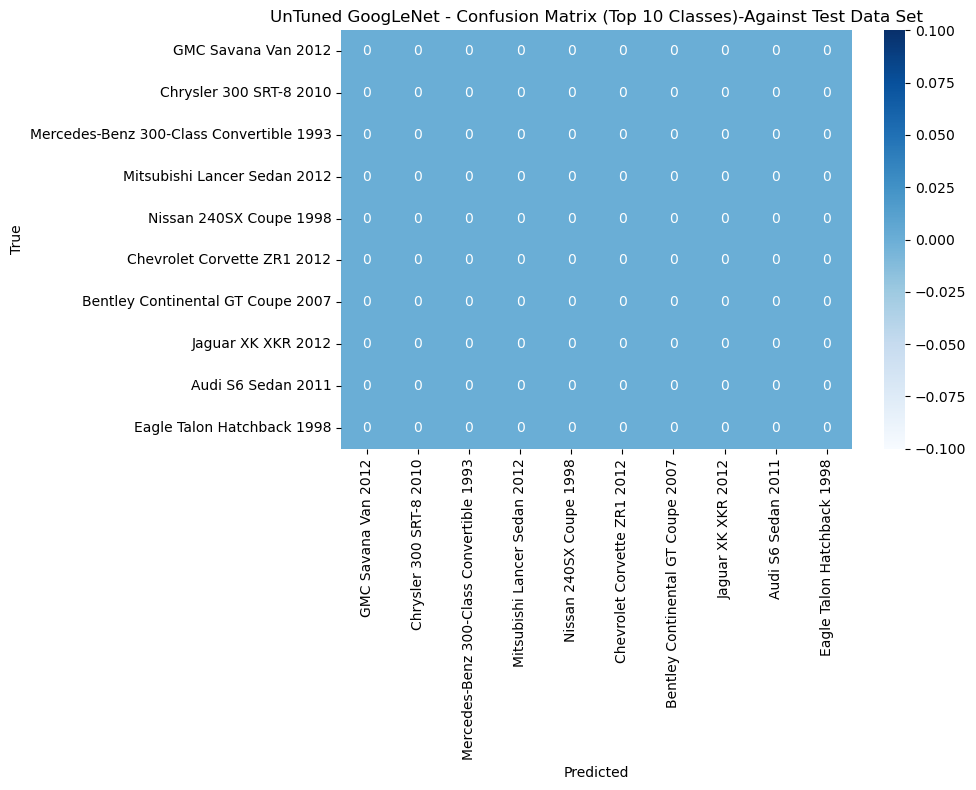

In [151]:
plt.figure(figsize=(10, 8))
sns.heatmap(cm_top10, annot=True, fmt='d',
            xticklabels=top_10_classes,
            yticklabels=top_10_classes,
            cmap='Blues')
plt.title("UnTuned GoogLeNet - Confusion Matrix (Top 10 Classes)-Against Test Data Set")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

 ### **Final Outcome (Test Data Evaluation)**

- **The untuned GoogLeNet model achieved a test accuracy of 21.94%, closely aligning with its validation performance (~22.90%).** 
- **The macro and weighted average F1-scores (~0.205) indicate a reasonable baseline performance across 196 fine-grained car classes.**
- **This confirms the model has learned meaningful patterns and generalizes well, though this model requires further tuning/training/restructuring would be required**
##### ***The GoogleNet is a pure classification model and does not support localization or masking of car regions in images***
##### ***Since RCNN and its hybrids require a base model capable of region proposals or feature maps for bounding box regression and segmentation***
#####  ***As the current GoogLeNet model is not suitable for region-based masking required in RCNN workflows, we will move forward with implementing YOLO for object detection and localization.***